# <font color=#a2006d>DATA660 Unit 6 Assignment - Jewell Powers</font>

#### <font color=#bd33a4>Due 04/22/2025</font>

#### <font color=#bd33a4>Google Colab Setup</font>

In [23]:
# ─── Setup cell ───
#!pip install pycaret
#!pip install numpy==2.0.4 pandas==2.2.2 scikit-learn==1.4.2 matplotlib==3.8.0

"""
Any time you do a full “Restart runtime” in Colab, it wipes out all your in‑memory installs and you’ll need to reinstall PyCaret (and any other libraries you added). Colab’s VMs are ephemeral, so your installs only persist until the next restart or disconnect.
"""
"""
Do NOT need to run --upgrade every time unless:

--> You specifically want to check for a newer version of PyCaret than the one you already installed, or

--> Your notebook is failing due to version mismatches and you’re troubleshooting with a fresh install.
"""

'\nDo NOT need to run --upgrade every time unless:\n\n--> You specifically want to check for a newer version of PyCaret than the one you already installed, or\n\n--> Your notebook is failing due to version mismatches and you’re troubleshooting with a fresh install.\n'

In [22]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

### Runtime → Change runtime type → Hardware accelerator: None or GPU (T4)
### This conserves your A100 stash for the big stuff.

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


### <font color=#bd33a4>LIBRARIES</font>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import setup, compare_models, pull
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score


In [ ]:
#!pip install pycaret

#!pip install --upgrade \
#    numpy==2.0.4 \
#    pandas==2.2.2 \
#    matplotlib==3.8.0 \
#    scikit-learn==1.4.2

#!pip install --upgrade pycaret

#Restart the runtime again

### <font color=#bd33a4>LOAD DATA</font>

In [3]:
#import os
#print(os.listdir('/content'))
df = pd.read_csv('/content/Prosper_data_set.csv')
print(df.shape)
df.head()

(34685, 43)


,ActiveProsperLoans,AmountRequested,BidCount,BorrowerMaximumRate,BorrowerRate,BorrowerState,Category,CreationDate,CreditGrade,CreditScoreRangeLower,...,CreationDate.hour,CreationDate.minute,CreationDate.second,StartDate.year,StartDate.month,StartDate.day-of-month,StartDate.day-of-week,StartDate.hour,StartDate.minute,StartDate.second
0,0.0,15000.0,241,0.1874,0.1874,NC,3,2011-07-19T13:25:29Z,NaN,660,...,13,25,29,2012,4,4,3,17,0,3
1,0.0,5000.0,76,0.1902,0.1902,MN,1,2011-07-21T09:52:49Z,NaN,680,...,9,52,49,2012,4,26,4,17,0,3
2,NaN,6500.0,140,0.0749,0.0749,IL,1,2011-08-03T06:02:59Z,NaN,800,...,6,2,59,2012,6,26,2,9,0,5
3,NaN,15000.0,235,0.1845,0.1845,TN,1,2011-09-15T13:58:23Z,NaN,760,...,13,58,23,2012,3,27,2,18,11,21
4,NaN,15000.0,234,0.1845,0.1845,MD,1,2011-09-22T06:45:57Z,NaN,740,...,6,45,57,2012,3,12,1,17,0,3


### <font color=#bd33a4>EDA</font>

In [4]:
#from previous assignments, I know I need to set a binary threshold for my target
threshold = 0.222
df['BorrowerRateBinary'] = (df['BorrowerRate'] > threshold).astype(int)

print("Threshold:", threshold)
print(df['BorrowerRateBinary'].value_counts())

Threshold: 0.222
BorrowerRateBinary
0    17505
1    17180
Name: count, dtype: int64


*I am using the same dataset and variables per instructions so that I can compare results across assignment modeling strategies but I will still go through the exploratory steps because that is never "optional"*

In [5]:
#overall structure
df.info()

#descriptive statistics for numeric columns
df.describe()

#check for missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("Columns with missing values:\n", missing[missing > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34685 entries, 0 to 34684
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ActiveProsperLoans                   6691 non-null   float64
 1   AmountRequested                      34685 non-null  float64
 2   BidCount                             34685 non-null  int64  
 3   BorrowerMaximumRate                  34685 non-null  float64
 4   BorrowerRate                         34685 non-null  float64
 5   BorrowerState                        34685 non-null  object 
 6   Category                             34685 non-null  int64  
 7   CreationDate                         34685 non-null  object 
 8   CreditGrade                          0 non-null      float64
 9   CreditScoreRangeLower                34685 non-null  int64  
 10  CreditScoreRangeUpper                34685 non-null  int64  
 11  DebtToIncomeRatio           

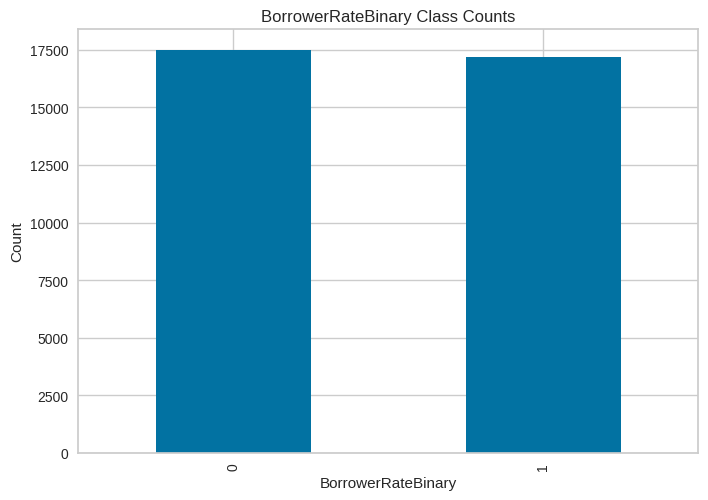

In [6]:
#wxamine target class balance (or imbalance)
counts = df['BorrowerRateBinary'].value_counts()
plt.figure()
counts.plot(kind='bar')
plt.title('BorrowerRateBinary Class Counts')
plt.xlabel('BorrowerRateBinary')
plt.ylabel('Count')
plt.show()

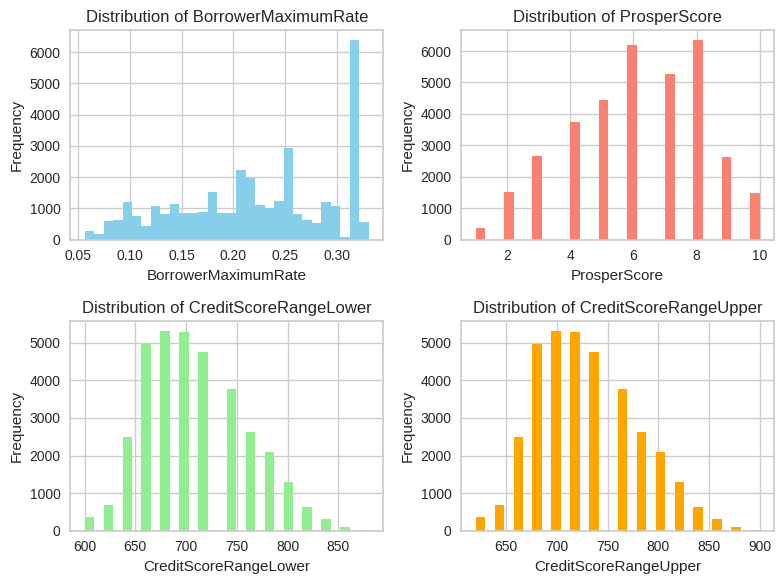

In [7]:
#view pre-selected feature variables
y_cols = [
    'BorrowerMaximumRate',
    'ProsperScore',
    'CreditScoreRangeLower',
    'CreditScoreRangeUpper'
]
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for ax, col, color in zip(axes, y_cols, colors):
    ax.hist(df[col], bins=30, color=color)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

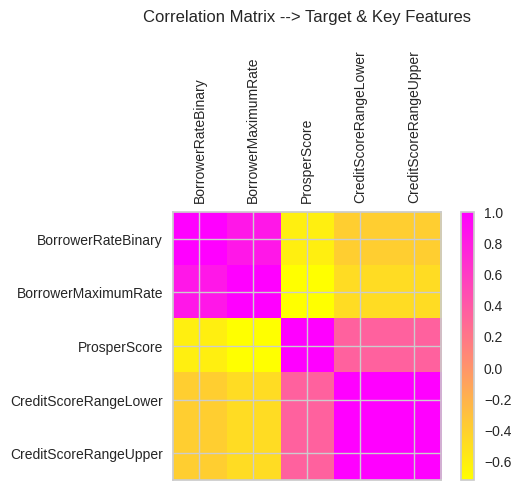

In [8]:
cols = [
    'BorrowerRateBinary',
    'BorrowerMaximumRate',
    'ProsperScore',
    'CreditScoreRangeLower',
    'CreditScoreRangeUpper'
]

subset = df[cols]
corr = subset.corr()
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(corr, cmap='spring_r')
fig.colorbar(cax)

ax.set_xticks(range(len(cols)))
ax.set_yticks(range(len(cols)))
ax.set_xticklabels(cols, rotation=90)
ax.set_yticklabels(cols)

plt.title('Correlation Matrix --> Target & Key Features', pad=20)
plt.tight_layout()
plt.show()

In [10]:
#create dataframe with features
keep_cols = [
    'BorrowerMaximumRate',
    'ProsperScore',
    'CreditScoreRangeLower',
    'CreditScoreRangeUpper',
    'BorrowerRateBinary'
]
prep_df = df[keep_cols].dropna()

In [11]:
# subset variables
keep_cols = [
    'BorrowerMaximumRate',
    'ProsperScore',
    'CreditScoreRangeLower',
    'CreditScoreRangeUpper',
    'BorrowerRateBinary'
]
subset = df[keep_cols]

#count missing per column
missing_per_col = subset.isna().sum()
print("Missing values per column:\n", missing_per_col)

#total rows with any missing in those columns
total_missing = subset.isna().any(axis=1).sum()
print(f"Total rows with ≥1 NaN in these columns: {total_missing}")

Missing values per column:
 BorrowerMaximumRate      0
ProsperScore             0
CreditScoreRangeLower    0
CreditScoreRangeUpper    0
BorrowerRateBinary       0
dtype: int64
Total rows with ≥1 NaN in these columns: 0


In [12]:
#count duplicates in subset
num_dups = subset.duplicated().sum()
print(f"Number of duplicate rows based on key features: {num_dups}")

#show duplicates in subset only
if num_dups > 0:
    dup_rows = subset[subset.duplicated(keep=False)]
    display(dup_rows)
"""
A total of 31,120 rows were identified as duplicates - these are not data entry errors, but rather reflect many borrowers sharing the same credit score range, Prosper Score, and maximum borrower rate. As such, no rows were removed.
"""

Number of duplicate rows based on key features: 31120


,BorrowerMaximumRate,ProsperScore,CreditScoreRangeLower,CreditScoreRangeUpper,BorrowerRateBinary
0,0.1874,4,660,680,0
1,0.1902,5,680,700,0
2,0.0749,10,800,820,0
3,0.1845,8,760,780,0
4,0.1845,8,740,760,0
...,...,...,...,...,...
34680,0.2492,2,720,740,1
34681,0.2419,3,700,720,1
34682,0.2639,2,760,780,1
34683,0.2049,4,680,700,0


'\nA total of 31,120 rows were identified as duplicates - these are not data entry errors, but rather reflect many borrowers sharing the same credit score range, Prosper Score, and maximum borrower rate. As such, no rows were removed.\n'

##### Descriptive Statistics


In [13]:
#---descriptive statistics---

for col in subset.columns:
    Q1 = subset[col].quantile(0.25)
    Q3 = subset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Boolean mask of outliers
    mask = (subset[col] < lower_bound) | (subset[col] > upper_bound)
    num_outliers = mask.sum()

    print(f"{col}: {num_outliers} outliers")

    # Optional: View a sample of those outliers
    if num_outliers > 0:
        display(subset.loc[mask, [col]].head())

BorrowerMaximumRate: 0 outliers
ProsperScore: 0 outliers
CreditScoreRangeLower: 417 outliers


,CreditScoreRangeLower
98,840
160,860
177,840
241,840
250,860


CreditScoreRangeUpper: 417 outliers


,CreditScoreRangeUpper
98,860
160,880
177,860
241,860
250,880


BorrowerRateBinary: 0 outliers


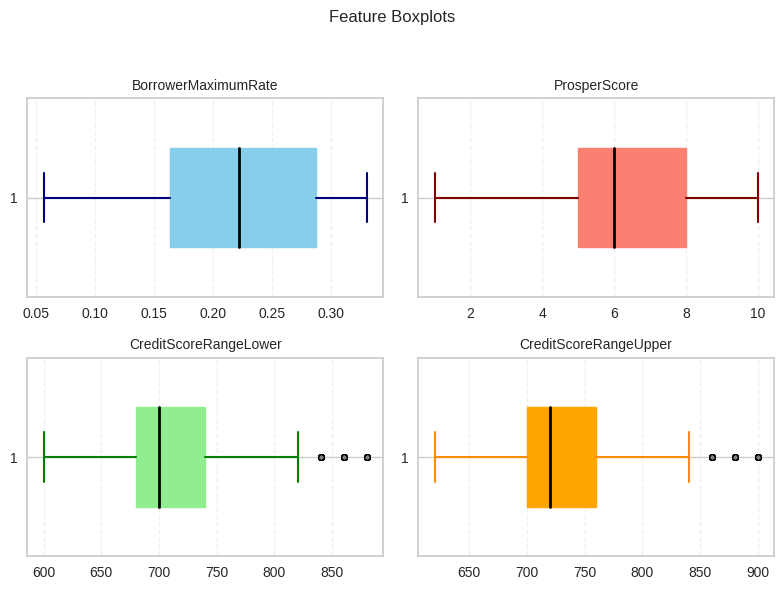

In [14]:
#box and whisker plots to visualize outliers

box_colors    = ['skyblue', 'salmon', 'lightgreen', 'orange']
whisker_colors= ['navy', 'maroon', 'green', 'darkorange']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for ax, col, bc, wc in zip(axes, subset.columns, box_colors, whisker_colors):
    bp = ax.boxplot(
        subset[col],
        vert=False,
        widths=0.5,
        patch_artist=True,
        boxprops={'facecolor': bc, 'edgecolor': bc},
        whiskerprops={'color': wc, 'linewidth': 1.5},
        capprops={'color': wc, 'linewidth': 1.5},
        medianprops={'color': 'black', 'linewidth': 2},
        flierprops={'marker': 'o', 'markerfacecolor': 'gray', 'markersize': 4}
    )
    ax.set_title(col, fontsize=10)
    ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.suptitle("Feature Boxplots", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [15]:
subset.describe()

,BorrowerMaximumRate,ProsperScore,CreditScoreRangeLower,CreditScoreRangeUpper,BorrowerRateBinary
count,34685.000000,34685.000000,34685.000000,34685.000000,34685.000000
mean,0.220639,6.116016,708.449186,728.449186,0.495315
std,0.074124,2.114208,49.866701,49.866701,0.499985
min,0.056500,1.000000,600.000000,620.000000,0.000000
25%,0.163900,5.000000,680.000000,700.000000,0.000000
50%,0.222000,6.000000,700.000000,720.000000,0.000000
75%,0.287000,8.000000,740.000000,760.000000,1.000000
max,0.330400,10.000000,880.000000,900.000000,1.000000


### <font color=#bd33a4>Preprocessing</font>

All data preprocessing tasks—including scaling, transformation, missing value imputation, and class imbalance handling—were performed within PyCaret’s setup() function.
https://pycaret.gitbook.io/docs/get-started/preprocessing/data-preparation

### <font color=#bd33a4>Preprocess and create PyCaret Model</font>

In [20]:
#subset to key features + target ensuring i am working with a cleaned  version to demarcate a clean line between raw-ish subset and fully prepped data for myself and gives me the flexibility to reference either one later if needed

cols = [
    'BorrowerMaximumRate',
    'ProsperScore',
    'CreditScoreRangeLower',
    'CreditScoreRangeUpper',
    'BorrowerRateBinary'
]
prep_df = df[cols].dropna()

### PyCaret setup with preprocessing handled internally
clf_setup = setup(
    data=prep_df,
    target='BorrowerRateBinary',
    train_size=0.8,
    session_id=21,

    normalize=True,
    transformation=True,
    numeric_imputation='median',
    categorical_imputation='mode',

    fix_imbalance=True,
    fix_imbalance_method='SMOTE',

    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,

    verbose=True
)

,Description,Value
0,Session id,21
1,Target,BorrowerRateBinary
2,Target type,Binary
3,Original data shape,"(34685, 5)"
4,Transformed data shape,"(34945, 4)"
5,Transformed train set shape,"(28008, 4)"
6,Transformed test set shape,"(6937, 4)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


Model Comparison

In [21]:
best_model = compare_models()

#pull the results table into a df
results_df = pull()

#preview
#results_df.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0430
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1150
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0430
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1280
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,19.7480
et,Extra Trees Classifier,0.9996,1.0000,0.9995,0.9997,0.9996,0.9992,0.9992,0.1110
xgboost,Extreme Gradient Boosting,0.9991,1.0000,0.9987,0.9995,0.9991,0.9982,0.9982,0.1250
lr,Logistic Regression,0.9986,1.0000,0.9976,0.9996,0.9986,0.9972,0.9972,0.5200
knn,K Neighbors Classifier,0.9978,0.9994,0.9977,0.9979,0.9978,0.9956,0.9956,0.3460
svm,SVM - Linear Kernel,0.9963,1.0000,0.9972,0.9954,0.9963,0.9926,0.9926,0.0450


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.043
rf,Random Forest Classifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.115
ada,Ada Boost Classifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.043
gbc,Gradient Boosting Classifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.128
lightgbm,Light Gradient Boosting Machine,1.0,1.0,1.0,1.0,1.0,1.0,1.0,19.748


from matplotlib import pyplot as plt
_df_0['TT (Sec)'].plot(kind='hist', bins=20, title='TT (Sec)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Accuracy']
  ys = series['TT (Sec)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('TT (Sec)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['AUC']
  ys = series['TT (Sec)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('AUC', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('AUC')
_ = plt.ylabel('TT (Sec)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['AUC']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'AUC'}, axis=1)
              .sort_values('AUC', ascending=True))
  xs = counted['AUC']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('AUC', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('AUC')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['TT (Sec)'].plot(kind='line', figsize=(8, 4), title='TT (Sec)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='TT (Sec)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# **---END---**